# core

> Basic functions and classes used in the library

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import patch
from fastcore.foundation import add_docs
from __future__ import annotations
import time
%load_ext autoreload
%autoreload 2

In [ ]:
#| export 
from __future__ import annotations
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional, Callable
from torch import nn
from fastcore.foundation import add_docs
import inspect 
from fastcore.basics import patch
import collections
from matplotlib_inline import backend_inline
from IPython import display
import time

## Utilities

In [ ]:
#| export
def init_cnn(module # either nn.Linear or nn.Conv2d
            ):
    "Initialize weights for neural net layer with xavier uniform initializer."

    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [ ]:
model = nn.Linear(2, 3)
nn.init.ones_(model.weight)

Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]], requires_grad=True)

In [ ]:
init_cnn(model)
model.weight

Parameter containing:
tensor([[-0.9805,  0.6248],
        [ 0.7421,  0.3259],
        [ 0.1148, -0.7342]], requires_grad=True)

In [ ]:
#| export
class HyperParameters:
    "Inherit from this class to save all non-ignored arguments in a class `__init__` method as attributes."
    
    def save_hyperparameters(self, 
                             ignore = [] #  list of argument names (string) to ignore when calling `setattr`
                            ):

        # Get the next outer frame object (this frame’s caller) -
        # `__init__` method.
        frame = inspect.currentframe().f_back
        # Get information about arguments passed into a particular frame.
        _, _, _, local_vars = inspect.getargvalues(frame)

        self.hparams = {
            k: v for k, v in local_vars.items()
            # ignore 'self', any variable in `ignore` list and
            # that not starts with the underscore.
            if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            # set attributes of a class
            setattr(self, k, v)

In [ ]:
show_doc(HyperParameters.save_hyperparameters)

---

[source](https://github.com/Iamalos/dlnb/blob/main/dlnb/core.py#L32){target="_blank" style="float:right; font-size:smaller"}

### HyperParameters.save_hyperparameters

>      HyperParameters.save_hyperparameters (ignore=[])

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| ignore | list | [] | list of argument names (string) to ignore when calling `setattr` |

After inheriting from `HyperParameters` you can save all arguments in a class `__init__` method as class attributes.

In [ ]:
class Person(HyperParameters):
    def __init__(self, name, age, sex, _internal='secret'):
        self.save_hyperparameters(ignore=['sex'])
        
jack = Person("Billy", 25, 'male')

In [ ]:
test_eq(jack.name, "Billy")

Ignores `self`, any variables in `ignore` list and that starts with
the underscore.

In [ ]:
test_fail(lambda: jack.sex, contains="'Person' object has no attribute 'sex'")
test_fail(lambda: jack._internal, contains="'Person' object has no attribute '_internal'")

In [ ]:
#| export
def add_to_class(Class):
    """Adds a method to a class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

For interactive development and 'monkey patching'.

In [ ]:
class Car:
    pass

@add_to_class(Car)
def start(self):
    return 'Car started'

In [ ]:
car = Car()
test_eq(car.start(), 'Car started')

In [ ]:
#| export

def cpu():
    return torch.device('cpu')


def gpu(i: int = 0):
    return torch.device(f'cuda:{i}')


def get_num_gpus():
    "Return number of gpus."
    return torch.cuda.device_count()


def try_gpu(i: int = 0):
    "Return gpu(i) if exists, otherwise return cpu()."
    if get_num_gpus() >= i + 1:
        return gpu(i)
    return cpu()

## Plotting

In [ ]:
#| exporti
def use_svg_display():
    "Use the svg format to display a plot in Jupyter."
    backend_inline.set_matplotlib_formats('svg')

In [ ]:
#| export
class ProgressBoard(HyperParameters):
    "Plots data in animation."
    
    def __init__(
        self,
        xlabel: Optional[str] = None, # label for `x` axis
        ylabel: Optional[str] = None, # label for `y` axis
        xlim: Optional[float] = None, # `x` limit values
        ylim: Optional[float] = None, # `y` limit values
        xscale: str = 'linear', # x scale, defaults to 'linear
        yscale: str = 'linear', # y scale, defaults to 'linear
        ls = ['-', '--', '-.', ':'], # list of linestyles to be used
        colors = ['C0', 'C1', 'C2', 'C3'], # list of colors to be used
        fig: Optional[plt.Figure] = None, # figure
        axes: Optional[plt.Axes] = None, # axes to be used for plotting. If this is not provided, creates new axes
        figsize: Tuple[float, float] = (3.5, 2.5), # size of the figure to be displayed
        display: bool = True # whether to show the plot
    ):

        self.save_hyperparameters()
        
    
    def _set_graph_params(self, lines, labels):
        
        axes = self.axes if self.axes else plt.gca()

        # Set axis limits, labels and scale.

        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)

        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)

        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        
        axes.legend(lines, labels)

    def draw(
        self,
        x, # x numeric values
        y, # y numeric values
        label: str, # label of a line to be plotted
        every_n: int = 1 # over what range to average the data. Defaults to one in which case every point is plotted
    ):
       
        "Interactively plot `x` and `y`."

        # Store pairs of x and y in a named tuple for ease of use.
        Point = collections.namedtuple('Point', ['x', 'y'])

        # Initialize `_raw_points` and `data` ordered dicts.
        if not hasattr(self, 'data'):
            self._raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.data:
            self._raw_points[label] = []
            self.data[label] = []

        # Copy `_raw_points` and `data` for a label to temporary arrays.
        # When points and line changes, `self._raw_points`` and `self.data`
        # changes as well.
        points = self._raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))

        # Accumulate points in `points` array until
        # there are `every_n` items.
        if len(points) != every_n:
            return

        def mean(x): return sum(x) / len(x)

        # Add to line array averaged x and y points to plot.
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))

        # clear points array after reaching `every_n` items.
        points.clear()

        if not self.display:
            return

        use_svg_display()

        # Prepare for the first plotting.
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []

        for (k, v), ls, color, in zip(self.data.items(), self.ls, self.colors):
            # store in array to later call `axes.legend`
            plt_lines.append(plt.plot(
                [p.x for p in v],
                [p.y for p in v],
                linestyle=ls,
                color=color)[0]
            )
            labels.append(k)

        self._set_graph_params(plt_lines, labels)

        display.display(self.fig)
        # To plot on the same graph
        display.clear_output(wait=True)

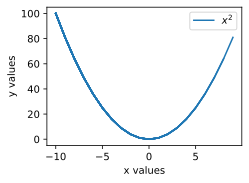

In [ ]:
a = ProgressBoard(xlabel = 'x values', ylabel = 'y values')
y = lambda x: x**2
for x in range(-10, 10):
    a.draw(x, y(x), '$x^2$')

## Building Modules

In [ ]:
#| export
class Module(nn.Module, HyperParameters):
    "The base class for all the models in the Diving into DL course"

    def __init__(
        self: Module,
        plot_train_per_epoch: int = 2, # number of training plot updates per one epoch
        plot_valid_per_epoch: int = 1 # number of validation plot updates per one epoch
    ):
        super().__init__()
        self.save_hyperparameters()
        self.board = ProgressBoard() # ProgressBoard for plotting data


    def loss(self: Module, 
             y_hat, # predicted y values
             y): # real y values
        raise NotImplementedError

    def forward(self: Module, 
                X # input tensor
               ):
        # make sure class has `net` attribute
        assert hasattr(self, 'net'), 'Neural network is not defined.'
        return self.net(X)  

    def plot(self: Module,
             key: str, # name of the metric to plot (e.g. `loss`, `accuracy`)
             value, # value to plot
             train: bool # train or validation
            ):

        assert hasattr(self, 'trainer'), 'Trainer is not inited.'
        self.board.xlabel = 'epoch'
        if train:
            # train_batch_idx is calculated as epoch * num_train_batches,
            # so to convert it to epochs, divide by num_train_batches.
            # x is an epoch (x-axis for plot)
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            # frequency of updates within one epoch. E.g. if 4 batches per
            # one epoch and `plot_train_per_epoch` is 2, then we need to
            # update the graph every 2 batches.
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch

        self.board.draw(x,
                        numpy(to(value, cpu())),
                        ('train_' if train else 'val_') + key,
                        every_n=int(n))

    def training_step(self: Module,
                      batch # list of X and Y sampled values.
                     ):
            
            # batch consists of [X, Y]
            # so *batch[:-1] takes X values and
            # batch[-1] takes Y values
            loss = self.loss(self(*batch[:-1]), batch[-1])
            self.plot('loss', loss, train=True)
            return loss

    def validation_step(self: Module,
                        batch # List of X and Y sampled values.
                       ):
        loss = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', loss, train=False)

    def apply_init(self: Module,
                   inputs, # Input tensor required to initialize lazy layers
                   init: Callable = None # Initialization function for each layer
                  ):
       
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

    def configure_optimizers(self: Module):
        
        raise NotImplementedError

In [ ]:
#| export
add_docs(Module,
         loss = "Calculate loss between fitted values and observed values.",
         forward = "Make a forward pass on the data.",
         plot = "Plots training or validation metric.",
         training_step = "Calculate loss for training batch and call `plot` method.",
         validation_step = "Calculate loss for validation data and call `plot` method.",
         apply_init =  "Apply `init` function to each layer of a net.",
         configure_optimizers = "Configure optimizers for training the `model`."
        )

In [ ]:
show_doc(Module)

---

[source](https://github.com/Iamalos/dlnb/blob/main/dlnb/core.py#L192){target="_blank" style="float:right; font-size:smaller"}

### Module

>      Module (plot_train_per_epoch:int=2, plot_valid_per_epoch:int=1)

The base class for all the models in the Diving into DL course

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| plot_train_per_epoch | int | 2 | number of training plot updates per one epoch |
| plot_valid_per_epoch | int | 1 | number of validation plot updates per one epoch |

Basis building block for custom models in the course that includes the basic pipeline of training a neural net:
`training step` function

In [ ]:
#| export
class DataModule(HyperParameters):
    "The base class for the data."
    
    def __init__(self, root: str = '../data', num_workers: int = 4):
        self.save_hyperparameters()

    def get_tensorloader(
        self,
        tensors: List[torch.Tensor], # list of tensors (e.g. Xs and ys).
        train: bool, # rue if DataLoader for training.
        indices: slice = slice(0, None) # slice to be used on tensors to create a DataLoader. None means to the end
    ) -> torch.utils.data.DataLoader:
  
        # for each tensor in tensors select a slice given by indices
        tensors = [tensor[indices] for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=train)

    def get_dataloader(self, train: bool):
        return NotImplementedError

    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

The base class for the data. A data loader is a generator that yields a batch of data every time
it is called. The batch is then fed into the `training_step` method
of `Module` to compute loss.

In [ ]:
#| export
add_docs(DataModule,
         get_tensorloader = " Create torch DataLoader from the tensors.",
         train_dataloader = "Return the train dataloader",
         val_dataloader = "Return the validation dataloader",
         get_dataloader = "not implemented")

In [ ]:
#| export

class Trainer(HyperParameters):
    "Base class used to train learnable parameters."

    def __init__(
        self,
        max_epochs: int, # number of epochs to run train.
        num_gpus: int = 0, # number of gpus to use when on gpu
        gradient_clip_value = 0
    ):
        self.save_hyperparameters()
        self.gpus = [gpu(i) for i in range(min(num_gpus, get_num_gpus()))]

    def prepare_data(self, data: DataModule):
        self.train_dataloader = data.train_dataloader()
        self.val_dataloader = data.val_dataloader()
        self.num_train_batches = len(self.train_dataloader)
        self.num_val_batches = (len(self.val_dataloader)
                                if self.val_dataloader is not None else 0)

    def prepare_model(self, model: Module):
        model.trainer = self
        model.board.xlim = [0, self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model = model

    def fit(self, model: Module, data: DataModule):

        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        # why self.epoch?
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()

    def prepare_batch(self, batch: List[Tensor] # sample of data yielded by DataLoader.
                     ):
        
        if self.gpus:
            batch = [a.to(self.gpus[0]) for a in batch]
        return batch

    def fit_epoch(self):
        
        # from nn.Module - sets the model in a training mode
        self.model.train()
        
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_value > 0:
                    print("NOT IMPLEMENTED YET")
                    self.clip_gradients(self.gradient_clip_value, self.model)
                self.optim.step()
            self.train_batch_idx += 1
            
        if self.val_dataloader is None:
            return
        # from nn.Module - sets the model in a training mode
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1

In [ ]:
#| export
add_docs(Trainer,
         prepare_data = "Prepare train and validation dataloaders",
         prepare_model = "Set trainer and model",
         fit = "Fit the model on data",
         prepare_batch = "Prepares the batch before training loop",
         fit_epoch = "Fit each training and (optonally) validation epoch"
         )

## Timer

In [ ]:
#| export
class Timer:
    "Record multiple running times."

    def __init__(self):
        "Inits Timer with empty array of `times` and starts it."
        self.times = []
        self.start()

    def start(self) -> None:
        self.tik = time.time()

    def stop(self) -> None:
        self.times.append(time.time()-self.tik)
        return self.times[-1]

    def avg(self) -> float:
        return sum(self.times) / len(self.times)

    def cumsum(self) -> List[float]:
        # casts list to numpy array to use `cumsum` f-n
        # then casts back to python list
        return np.array(self.times).cumsum().tolist()

In [ ]:
#| export
add_docs(Timer,
         start = "Start the timer",
         stop = "Stop the timer and record the time in a list",
         avg = "Return the average time",
         cumsum = "Return the accumulated time"
        )

`Timer.start` to start the timer and `Timer.stop` to end it. `Timer.avg` calculates the average running time

In [ ]:
timer = Timer()
timer.start()
time.sleep(0.5)

timer.stop()
timer.start()

time.sleep(1)
timer.stop()

test_close(timer.avg(), (0.5+1)/2, eps=1e-2)

In [ ]:
#| export
class Accumulator:
    "Accumulates sums over `n` variables."

    def __init__(self, n: int # length of an array
                ):
        "Inititalize with zeros an array of size `n`"

        self.data = [0.0] * n

    def add(self, *args):
        "Add new values to each corresponding position in the array."

        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        """Set all data entries of data to zero"""
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx: int):
        """Getter - simply return an element by index from self.data."""
        return self.data[idx]

Accumulates statistics over an array of lengths `n`. Each entry in an array represents `characteristic` over which new items to repsective array positions will be summed over.

In [ ]:
a = Accumulator(3)
a.add(1,2,3)
test_eq(a.data, [1.0, 2.0, 3.0])

a.add(1,1,1)
test_eq(a.data, [2.0, 3.0, 4.0])

a.reset()
test_eq(a.data, [0.0, 0.0, 0.0])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()